In [179]:
# Qué es el utils.py?

# Trabjo Práctico Integrador: GRUPO 8
## Autores:

- Choconi Lucas
- Berra Eliel
- Mina Federico
- Scillato German

## Importaciones y configuración

In [1]:
import os
from os import path
import time
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import requests
import warnings

from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix


from PIL import Image

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from tqdm import tqdm

from lime.lime_tabular import LimeTabularExplainer

from xgboost import XGBClassifier

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

import pickle

warnings.filterwarnings('ignore')

#### Configuración Gráficos y Path

In [2]:
# Configuración Graficos 

myColors = ((0.90, 0.96, 1, 1), (0.70, 0.87, 1, 1), (0, 0.40, 0.75, 0.88))
cmap = LinearSegmentedColormap.from_list('Custom', myColors,10)

# Fuente de titulos de gráficos
font = {'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

# Función para graficos de WorldCloud

def blue_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    """Argumentos de función necesarias para metodo worldcloud"""
    blues = "hsl(215,100%%, %d%%)" % np.random.choice(np.arange(25, 65, 5, dtype=int))
    reds = "hsl(0,100%%, %d%%)" % np.random.choice(np.arange(40, 80, 5, dtype=int))
    choice = np.random.choice([0, 1])
    if choice == 0:
        return blues
    else:
        return reds


def graficos_manos(fake,true):
    """Función para graficar worldcloud en forma de manos,
    falsas y verdaderas. Variables: worldcloud falsa y verdadera"""
    fig, axs = plt.subplots(1, 2,figsize=(20,10))  

    axs[1].imshow(fake.recolor(color_func=blue_color_func, random_state=3),
                interpolation="bilinear")
    axs[1].axis("off")
    axs[1].set_title('FAKE' , fontdict = font)
    axs[0].imshow(true.recolor(color_func=blue_color_func,random_state=3),
                interpolation="bilinear")
    axs[0].axis("off")
    axs[0].set_title('TRUE' , fontdict = font)
    plt.show()


In [8]:
# No entiendo qué hace path.dirname(__file__) if "__file__" in locals() else os.getcwd()
# no es más fácil poner ./ antes del path del archivo?
# Por qué se llama mask_pos la variable, es realmente una máskara o una matriz que se vuelve imagen?

In [3]:
# Importación de imagenes para graficos de manos.

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask_pos = np.array(Image.open(path.join(d, "./data/Thumbs.png")))
mask_neg = np.array(Image.open(path.join(d, "./data/Thumbsdw.png")))

## LOGICA DE DESARROLLO DEL MODELO
Se busco el conjunto de stopwords siguiendo el siguiente esquema

In [11]:
# Qué es NA? Creo que no vale la pena poner Formato Fecha
# No entiendo la relación entre No tiene sentido y peso predictivo > 0.3 
# Podríamos agregar el Pipeline, al final del flujo la prueba de Apis

![Diagrama](./data/fake_d.png)

## Limpieza de datos
Importación y limpieza del 
[Dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset)

In [4]:
# El dataset vino separado en las noticias Falsas y Verdaderas, así que se lo unifica con append 
# entre los archivos True.csv y Fake.csv

file_names_true = pd.read_csv('./data/True.csv')
file_names_true['real'] = 'True'
file_names_fake = pd.read_csv('./data/Fake.csv')
file_names_fake['real'] = 'Fake'
data = file_names_fake.append(file_names_true, ignore_index=True)
data.head(2)

,title,text,subject,date,real
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake


In [5]:
# Unimos el título y el contenido del artículo en una sola columna
data['text'] = data['title'] + ' --- ' + data['text'] 

# Ejemplo de 1 texto del dataset.
with pd.option_context('display.max_colwidth', None):
  print(data.head(1))
data = data.drop(columns = 'title')

                                                                             title  \
0   Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [6]:
# Algunas filas contienen datos erróneos que impiden transformar la columna 'date' a formato fecha
wrong_row = data['date'] == 'https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/'
data[wrong_row]

,text,subject,date,real
9358,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,Fake


In [7]:
# Las filas que no pueden ser correctamente transformadas a datetime
# serán utilizadas en una máscara booleana para poder eliminarlas

data['date'] = data['date'].apply(lambda x: pd.to_datetime(x,
                                                    infer_datetime_format = True)\
                                                    if re.search('[a-z-A-Z]+ [0-9]+, [0-9]{4}', x) else  np.NaN)
delete_mask = data['date'].notna()
data = data[delete_mask]
data = data.reset_index()
data['date'] = data['date'].astype('datetime64')

In [8]:
# Separamos los datos en dos máscaras con las filas que contienen noticias falsas de las que son reales
data_real = data[data['real'] == 'True']
data_fake = data[data['real'] == 'Fake']

# VALIDAR CON ELIEL O BORRAR

In [ ]:
# Tarda mucho en ejecutarse esto, para el viernes lo subo, va a aportar al análisis estadístico incial

In [9]:
'''
# Averiguamos cuál es el largo promedio de las noticias falsas y de las reales

data['text_len'] = data['text'].apply(lambda x: len(word_tokenize(x)))

# Gráfico comparativo del largo promedio de las noticias falsas y verdaderas
real_len_avg = data_real['text_len'].mean()
fake_len_avg = data_fake['text_len'].mean()
len_avgs = [real_len_avg, fake_len_avg]
plt.bar(['Real', 'Fake'], len_avgs)

# Lista con todas las palabras en inglés https://github.com/dwyl/english-words/blob/master/words.txt
all_eng_words = pd.read_csv('./data/all_english_words.csv')
all_eng_words = pd.Series(all_eng_words.iloc[:,0])
all_eng_words = all_eng_words.apply(lambda x: x.lower() if type(x) == str else x)

def words_percentage(text):
    # Devuelve el porcentaje de palabras que posee un texto que están dentro de un diccionario
    words = word_tokenize(text)
    words = [re.sub('[^A-Za-z0-9]+', '', word) for word in words] 
    words_in_dict = [word for word in words if word in all_eng_words.values]
    words_in_dict_percentage = len(words_in_dict) * 100 / len(words)
    return words_in_dict_percentage

tqdm.pandas()
data['words_in_dict_pct'] = data['text'].progress_apply(words_percentage)

new_dataset_location = './data/data_with_pct'
data.to_csv(new_dataset_location, index = False)

data2 = pd.read_csv(new_dataset_location)
data2
'''


"\n# Lista con todas las palabras en inglés https://github.com/dwyl/english-words/blob/master/words.txt\nall_eng_words = pd.read_csv('./data/all_english_words.csv')\nall_eng_words = pd.Series(all_eng_words.iloc[:,0])\nall_eng_words = all_eng_words.apply(lambda x: x.lower() if type(x) == str else x)\n\ndef words_percentage(text):\n    # Devuelve el porcentaje de palabras que posee un texto que están dentro de un diccionario\n    words = word_tokenize(text)\n    words = [re.sub('[^A-Za-z0-9]+', '', word) for word in words] \n    words_in_dict = [word for word in words if word in all_eng_words.values]\n    words_in_dict_percentage = len(words_in_dict) * 100 / len(words)\n    return words_in_dict_percentage\n\ntqdm.pandas()\ndata['words_in_dict_pct'] = data['text'].progress_apply(words_percentage)\n"

<Figure size 1440x432 with 0 Axes>

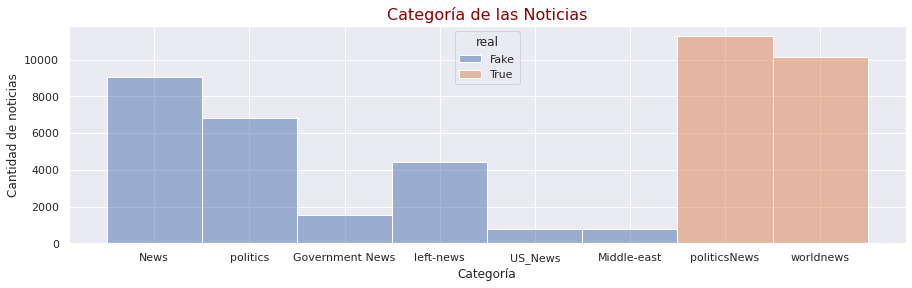

<Figure size 1440x432 with 0 Axes>

In [21]:
sns.set(rc={'figure.figsize':(15, 4)})
sns.histplot(data = data, x = 'subject', hue = 'real' )
plt.ylabel('Cantidad de noticias')
plt.xlabel('Categoría')
plt.title("Categoría de las Noticias", fontdict= font)
plt.figure(figsize=(20,6))

In [9]:
# Como hay valores diferentes en la columna "subject" para las noticias reales y las falsas borramos esa columna
data = data.drop(columns = 'subject')

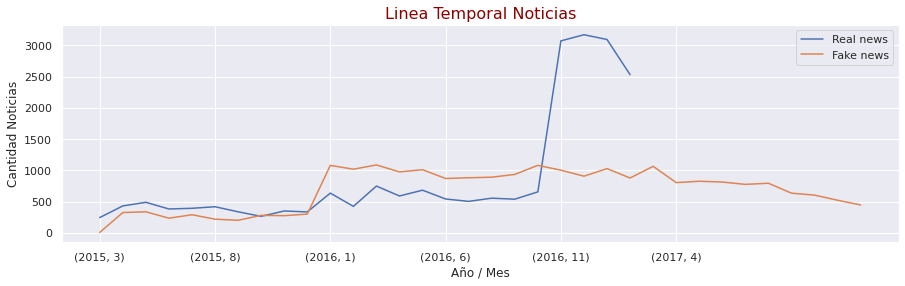

In [134]:
# Hacemos un gráfico mostrando el conteo de cuántas noticias falsas y cuántas verdaderas se publicaron 
# por mes en el dataset 
ax = data_real['date'].groupby([data_real["date"].dt.year,
                             data_real["date"].dt.month]).count().plot.line(label = 'Real news')

ax = data_fake['date'].groupby([data_fake["date"].dt.year,
                            data_fake["date"].dt.month]).count().plot.line(label = 'Fake news')
ax.set(xlabel=None)
ax.set_title('Linea Temporal Noticias' , fontdict = font)
ax.set_xlabel('Año / Mes')
ax.set_ylabel('Cantidad Noticias')
ax.legend()

El pico de noticias verdaderas publicadas en Noviembre del 2016 coincide con las elecciones presidenciales de Estados Unidos

Se verifica limpieza de dataset

In [24]:
# El dataset no valores nulos así que damos por finalizada la limpieza
print(data.isna().sum())

index    0
text     0
date     0
real     0
dtype: int64


# Pre-procesamiento

A partir del wordcloud se analiza el Dataset y se verifica inicialmente posible palabras a descartar

In [ ]:
# Este gráfico de las manitos no forma parte del pre-procesamiento, no debería ir más arriba con el Análisis 
# estadístico visual inicial?

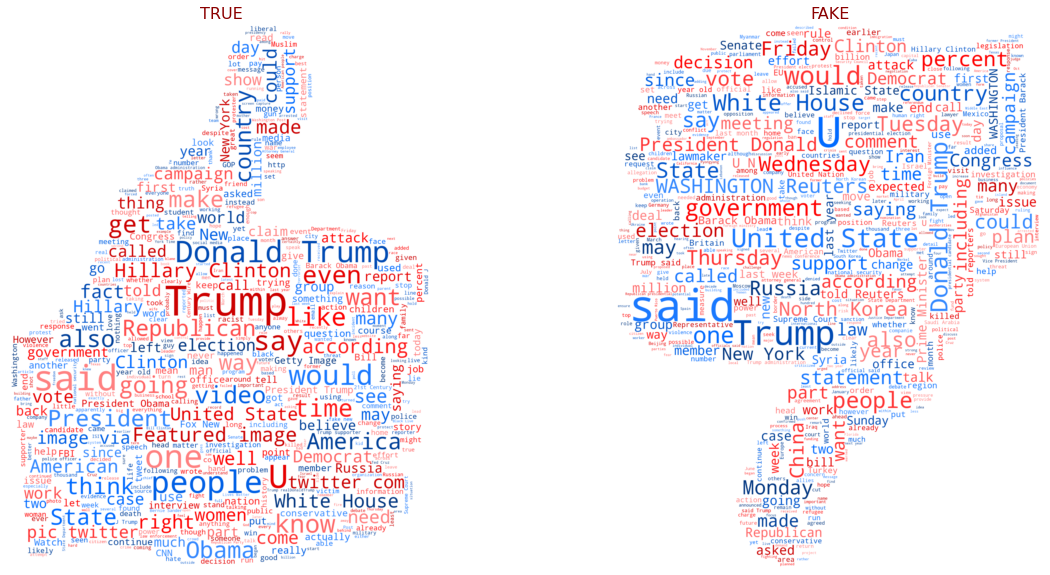

In [27]:
# Generamos un gráfico que muestra visualmente las palabras que más frecuentemente aparecen tanto en noticias
# falsas como verdaderas
wordcloud_fake = WordCloud(stopwords=stopwords_en,
            mask=mask_neg, 
            max_words=500,
            background_color="white").generate(data_real.text.str.cat(sep=' '))
wordcloud_true = WordCloud(stopwords=stopwords_en,
            mask=mask_pos,
            max_words=500,
            background_color="white").generate(data_fake.text.str.cat(sep=' '))


graficos_manos(fake = wordcloud_fake,true = wordcloud_true)

Se divide el dataset en train y test. 

In [11]:
# Algunas operaciones se demoran mucho tiempo debido a la gran cantidad de columnas que se generan al vectorizar
# los datos, el tamaño pequeño de la muestra es para agilizar las operaciones
testing_sample_size = 2000 
small_testing_sample_size = 100 # Para hacer testeos aún más rápidos se recomienda este sampleo 
data_sample = data.sample(small_testing_sample_size)
X = data_sample['text']
y = data_sample['real']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Para obtener la raiz de las palabras se utiliza [Porter Stemmer](https://www.nltk.org/_modules/nltk/stem/porter.html)

In [12]:
# Se utiliza este stemmer por default, y al obtenerse buenos resultados iniciales, se continua trabajando en el análisis
# de las features importance. 
# Es por esto que se descarta agregar otro stemmer al pipeline, ya que requeriria una nueva puesta de análisis de dichas palabras.

stopwords_en = stopwords.words('english')
porter = PorterStemmer()
stopwords_en_porter = [porter.stem(x) for x in stopwords_en]

In [9]:
# Quizás habría que mostrar primero el sobre ajuste del modelo antes de quitar las palabras de
# stopwords_agregar, y también mostrar cómo se hizo el porter_stem a ese listado.

In [13]:
# Agrego Stopwords específicas del dataset.

def append_stopword(listado_stopwords, stopwords_agregar):
    for stopwords in stopwords_agregar:
        listado_stopwords.append(stopwords)
    return listado_stopwords

stopwords_agregar = ['reuter','said','Reuters','via','imag','https','com','one',
'u','also','would','featur','pic','us','wednesday','friday','monday','tuesday',
'saturday','sunday','thursday','getti','read','gop','watch','donald','trump',
'hillari','mr','accord','america','seem','youtub','21st',
'video' , 'http' , 'like' , 'obama' , 'minist' , 'washington' , 'know' , ]

stopwords_en_porter = append_stopword(stopwords_en_porter ,stopwords_agregar )

In [14]:
# Definición de función para el tokenizer
def porter_tokenizer(text):
    ''' Esta función se utiliza cuando se sobre escribe el proceso
    de tokenización en la clase CountVectorizer para que se pueda
     obtener también la raíz de la palabra con el método Porter.'''
    porter = PorterStemmer()
    stopwords_en_porter = [porter.stem(x) for x in stopwords_en]
    words = word_tokenize(text)
    words = [re.sub('[^A-Za-z0-9]+', '', word) for word in words]  # remover los caracteres especiales
    words = [word.replace(' ', '') for word in words] #remover los espacios en blanco
    words = [word for word in words if word != '']
    words = [porter.stem(word) for word in words] # obtener la raiz de las palabras
    words = [word for word in words if word not in stopwords_en_porter] # remover las stopwords
    return words

In [15]:
# Definición de función para el tokenizer con Lancaster Stemmer que será utilizado en el pipeline
def lancaster_tokenizer(text):
    ''' Esta función se utiliza cuando se sobre escribe el proceso
    de tokenización en la clase CountVectorizer para que se pueda
     obtener también la raíz de la palabra con el ḿetodo Lancaster.'''
    lancaster = LancasterStemmer()
    stopwords_en_lancaster = [lancaster.stem(x) for x in stopwords_en]
    words = word_tokenize(text)
    words = [re.sub('[^A-Za-z0-9]+', '', word) for word in words]  # remover los caracteres especiales
    words = [word.replace(' ', '') for word in words] #remover los espacios en blanco
    words = [word for word in words if word != '']
    words = [lancaster.stem(word) for word in words] # obtener la raiz de las palabras
    words = [word for word in words if word not in stopwords_en_lancaster] # remover las stopwords
    return words

In [16]:
# La ventaja de este CountVectorizer es que incluye una función porter_tokenizer como parámetro que permite
# customizar el procedimiento para obtener la raíz de la palabra
customized_vectorizer= CountVectorizer(lowercase = True,
                                       strip_accents='unicode', 
                                       tokenizer = porter_tokenizer,
                                       ngram_range = (1, 3),
                                       min_df = 3)

customized_vectorizer_train = customized_vectorizer.fit_transform(X_train)
customized_vectorizer_test = customized_vectorizer.transform(X_test)

In [17]:
# Construcción de matrices tfidf
tfidf_matrix_train = TfidfTransformer().fit_transform(customized_vectorizer_train)
tfidf_matrix_test = TfidfTransformer().fit_transform(customized_vectorizer_test) 

### Cambio de Base

##### Evaluación del impacto con distintas cantidades de componentes

In [18]:
# Definición de función para cambio de base

def select_n_components(var_ratio, goal_var: float) -> int: 
    ''' Esta función se utiliza para hacer un cambio de base y lograr explicar
    el porcentaje de los datos que se pasa en el argumento goal_var.
    Fuente https://chrisalbon.com/code/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd/
    Fue modificada para que hiciera un gráfico de la varianza explicativa del
    modelo de acuerdo al número de componentes'''
    # Set initial variance explained so far
    total_variance = 0.0
    # Set initial number of features
    n_components = 0
    # Listas del nuḿero de componentes y de la explicación de varianza alcanzada para poder graficarlas
    num_components = list(range(1, len(var_ratio) + 1))
    variances = []
    # For the explained variance of each feature:
    found_n_components = False
    for explained_variance in var_ratio:
        # Add the explained variance to the total
        total_variance += explained_variance
        # Add one to the number of components
        n_components += 1
        # Agregar la varianza explicada al listado 
        variances.append(total_variance)
        # If we reach our goal level of explained variance and we haven't reached our desired variance
        if total_variance >= goal_var and found_n_components == False:
            desired_n_components = n_components
            found_n_components = True
            desired_variance = total_variance
    plt.plot(num_components, variances )
    plt.scatter(desired_n_components, desired_variance, c = 'r')
    plt.xlabel('Número de componentes')
    plt.ylabel('Razón de la explicación de la varianza')
    plt.hlines(desired_variance, 0, desired_n_components, 'r', 'dashed')
    plt.vlines(desired_n_components, 0, desired_variance, 'r', 'dashed')
    plt.title("Comparativa Varianza vs Número componentes ",fontdict=font)
        
    # Return the desired number of components. 
    # Tipo de variable devuelta definido por " -> int " PEP3107
    return desired_n_components

Para Threshold 0.9 número de componentes después del cambio de base: 57
Para Threshold 0.5 número de componentes después del cambio de base: 24
Para Threshold 0.1 número de componentes después del cambio de base: 4


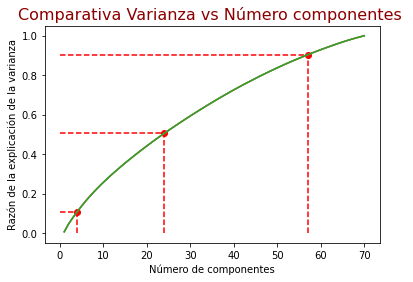

In [19]:
# Evaluación de cambio de base para 3 threshold
# Evaluamos cómo responde el cambio de base cuando seleccionamos una explicación
# de la varianza alta (0.9), media (0.5) o baja (0.1)
desired_threshold = [0.9 , 0.5 , 0.1]


# Tener en cuenta que si el número de filas de la matrix esparsa es menor al número de componentes elegido
# como hiperparámetro, una vez que se haya realizado la transformación SVD el número de componentes 
# obtenido será igual al número de filas de la matriz esparsa, y no será el número de componentes
# elegido como hiperpárametro
for thres in desired_threshold:
    test_svd = TruncatedSVD(n_components = tfidf_matrix_train.shape[1] - 1);
    test_svd.fit(tfidf_matrix_train)
    tsvd_var_ratios = test_svd.explained_variance_ratio_
    desired_threshold = thres
    n_components = select_n_components(tsvd_var_ratios, desired_threshold)

    print(f'Para Threshold {thres} número de componentes después del cambio de base: {n_components}')

##### Aplicacion SVD

Se concluye que se tiene una performance aceptable aunque solo se capture el 10% de la varianza del dataset. Por lo cual, en el pipeline se incluiran los 3 threshold.

In [49]:
# Feature Selection es lo que se hizo más arriba con el cambio de base en SVD
# No entiendo a qué se refieren con que se hizo de forma iterativa

## Feature Selection
Esta etapa de la construcción del modelo, se hizo de forma iterativa, verificando palabras que no tuvieran sentido real en la predicción de noticias falsas

In [43]:
# Habían dejado el data completo en vez del data_sample por algo en especial? si se deja dataset completo 
# se enlentece todo.
# Estamos repitiendo el proceso de vectorización.

In [144]:
# Se realiza la vectorización con el dataset completo.
customized_vectorizer_feature= CountVectorizer(lowercase = True,
                                        strip_accents='unicode', 
                                        tokenizer = porter_tokenizer,
                                        ngram_range = (1, 3),
                                        min_df = 0.002,
                                        max_df= 0.9)

customized_vectorizer_feature.fit(data_sample.text)
customized_vectorizer_matrix = customized_vectorizer_feature.transform(data_sample.text)

In [145]:
tfidf_matrix_feature = TfidfTransformer().fit_transform(customized_vectorizer_matrix)

In [54]:
# Podemos agregar alguna conclusión de esto, acá ya se debería ver el sobreajuste?

In [146]:
# Definición de modelo Tree para evaluar peso de cada palabra.
dt = tree.DecisionTreeClassifier(criterion='gini',
max_depth=4,min_samples_leaf=2)
dt.fit(tfidf_matrix_feature, data_sample["real"])
importancia_features = pd.DataFrame(dt.feature_importances_,
 index = customized_vectorizer_feature.get_feature_names(),
 columns=['importancia'])
importancia_features_sort = importancia_features.sort_values('importancia', ascending=False)
print(importancia_features_sort[0:10])

                       importancia
week                      0.303882
nation                    0.266761
spokesman                 0.156344
condit                    0.137101
media                     0.108568
help                      0.027343
1                         0.000000
polit somewhat rare       0.000000
polit professor queen     0.000000
polit risk                0.000000


### Robustez del modelo - Influencia de stopwords

Se detecto que el modelo sobreajuste para el dataset inicial, si no se retira las stopwords definidas. A continuación se muestra los resultados del modelo incluyendo dichas palabras. Se utiliza el modelo de "Tree" como ejemplo.

In [48]:
# No entiendo por qué están volviendo a armar de nuevo un sampleo y arriba se estaba trabajando con
# el dataset completo

In [ ]:
# Por qué se llama X_train_completo si está sampleado?

In [147]:
# Se redefine x_train y x_test

testing_sample_size = 1000 # Algunas operaciones se demoran mucho tiempo, tamaño pequeño es para agilizarlas

data_sample = data.sample(testing_sample_size)
X = data_sample['text']
y = data_sample['real']
X_train_completo, X_test_completo, y_train_completo, y_test_completo = train_test_split(X, y, test_size = 0.3)

In [ ]:
# Para qué están redefiniendo las stopwords y haciendo la vectoización?
# La función porter_tokenizer ya trabajaba con la raíz stopwords porterizada. 

In [148]:
# Se redefine stopwords y se genera nuevamente la vectorización, y la matriz tfidf

stopwords_en_porter = [porter.stem(x) for x in stopwords_en]
customized_vectorizer_feature= CountVectorizer(lowercase = True,
                                               strip_accents='unicode', 
                                               tokenizer = porter_tokenizer,
                                               ngram_range = (1, 3),
                                               min_df = 3)

customized_vectorizer_matrix = customized_vectorizer_feature.fit_transform(X_train_completo)
customized_vectorizer_test = customized_vectorizer_feature.transform(X_test_completo)

In [149]:
tfidf_matrix_train_completo = TfidfTransformer().fit_transform(customized_vectorizer_matrix)
tfidf_matrix_test_completo = TfidfTransformer().fit_transform(customized_vectorizer_test) 

X_train_completo= tfidf_matrix_train_completo
X_test_completo = tfidf_matrix_test_completo

In [150]:
# Modelo ejemplo para mostrar sobre ajuste.
my_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
my_tree.fit(X_train_completo , y_train_completo )
print("Score modelo con stopwords: ", round(my_tree.score(X_test_completo ,
                                            y_test_completo )))

Score modelo con stopwords:  1


In [ ]:
# Me está tirando 1 de accuracy, no sé si a uds les dio lo mismo pero esto está ultra overfiteado, si también
# les dio así de alto el accuracy podemos señalarlo

<Figure size 1440x432 with 0 Axes>

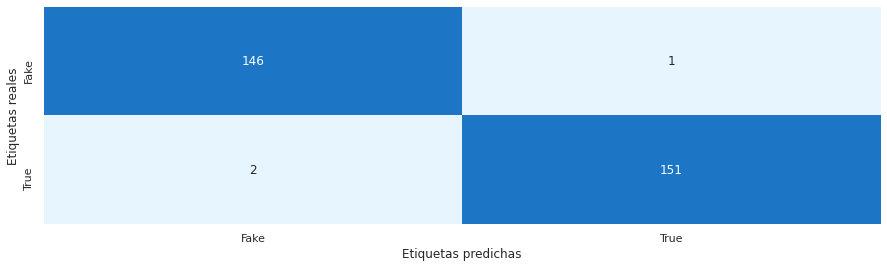

<Figure size 1440x432 with 0 Axes>

In [151]:
cm_tree = confusion_matrix(y_test_completo , my_tree.predict(X_test_completo ))

axis_labels = np.sort(y_test.unique())
sns.heatmap(cm_tree, xticklabels=axis_labels,yticklabels=axis_labels,
             cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');
plt.figure(figsize=(20,6))

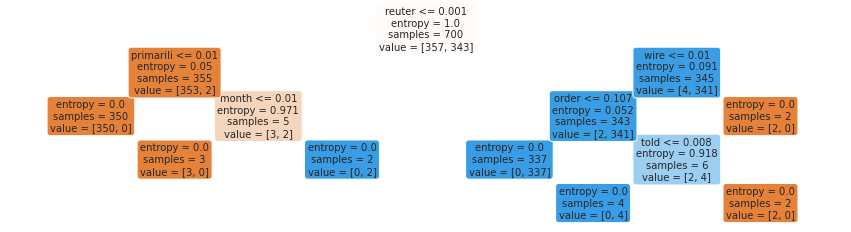

In [152]:
tree.plot_tree(my_tree,feature_names = customized_vectorizer_feature.get_feature_names(),
                filled=True,rounded=True, fontsize = 10)
plt.show()

# Modelos

In [78]:
# Para mí hagamos sin SVD, pero incluyámoslo en el Pipeline

In [180]:
# Por qué acá no usamos el X_train_completo?

In [155]:
# VAN CON SVD???? O SIN SVD???

X_train = tfidf_matrix_train
X_test = tfidf_matrix_test

In [66]:
# Podemos poner un mini gráfico mostrando el balanceo de la target para ver contra qué se está comparando 
# el accuracy

## Naive Bayes

In [156]:
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
NB_model.score(X_test, y_test)

0.9

Text(0.5, 12.5, 'Etiquetas predichas')

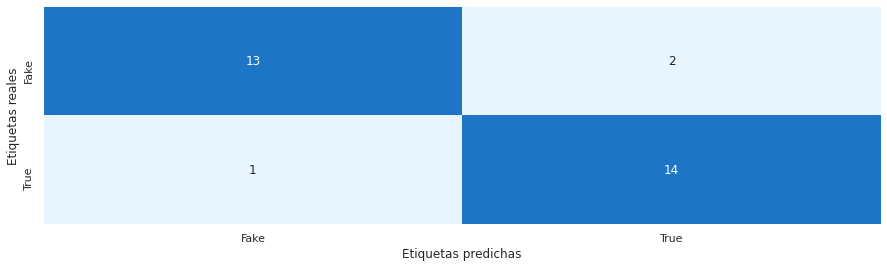

In [157]:
axis_labels = np.sort(y_test.unique())
cm_nb = confusion_matrix(y_test, NB_model.predict(X_test))
sns.heatmap(cm_nb, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')

#### Modelo de Reg. Logistica

In [158]:
reg_model = LogisticRegression(C = 7, solver="saga", l1_ratio=0.5 ,
                                 penalty="elasticnet", n_jobs=-1)
reg_model.fit(X_train, y_train)
reg_model.score(X_test, y_test)

0.8666666666666667

Text(0.5, 12.5, 'Etiquetas predichas')

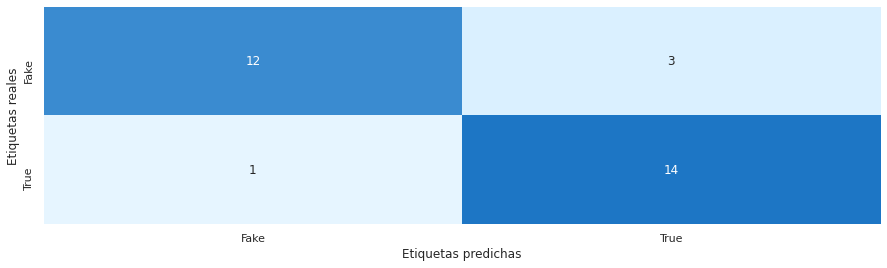

In [159]:
cm_rlog = confusion_matrix(y_test, reg_model.predict(X_test))
sns.heatmap(cm_rlog, xticklabels=axis_labels, yticklabels=axis_labels,
             cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')

In [160]:
Coef_reg_model = pd.DataFrame(np.transpose(reg_model.coef_), index=customized_vectorizer.get_feature_names(),
 columns=['Coef'])
Coef_reg_model['coef_abs'] = abs(Coef_reg_model['Coef'])
Coef_reg_model = Coef_reg_model.reset_index(-1)
Coef_reg_model['words'] = Coef_reg_model['index'] 
Coef_reg_model['freq'] = (round(Coef_reg_model['coef_abs'] / Coef_reg_model.coef_abs.sum()* Coef_reg_model.shape[0] * 1000 , 0)).apply(lambda x: int(x))
Coef_reg_model['odds_direction'] = Coef_reg_model['Coef'].apply(lambda x: 'Negative' if x<0 else 'Positive')

Coef_reg_model_positive = Coef_reg_model[Coef_reg_model['odds_direction']=='Positive']
Coef_reg_model_positive = Coef_reg_model_positive.drop(['Coef' ,'coef_abs', 'index', 'odds_direction'], axis=1)
Coef_reg_model_negative = Coef_reg_model[Coef_reg_model['odds_direction']=='Negative']
Coef_reg_model_negative = Coef_reg_model_negative.drop(['Coef' ,'coef_abs', 'index', 'odds_direction'], axis=1)

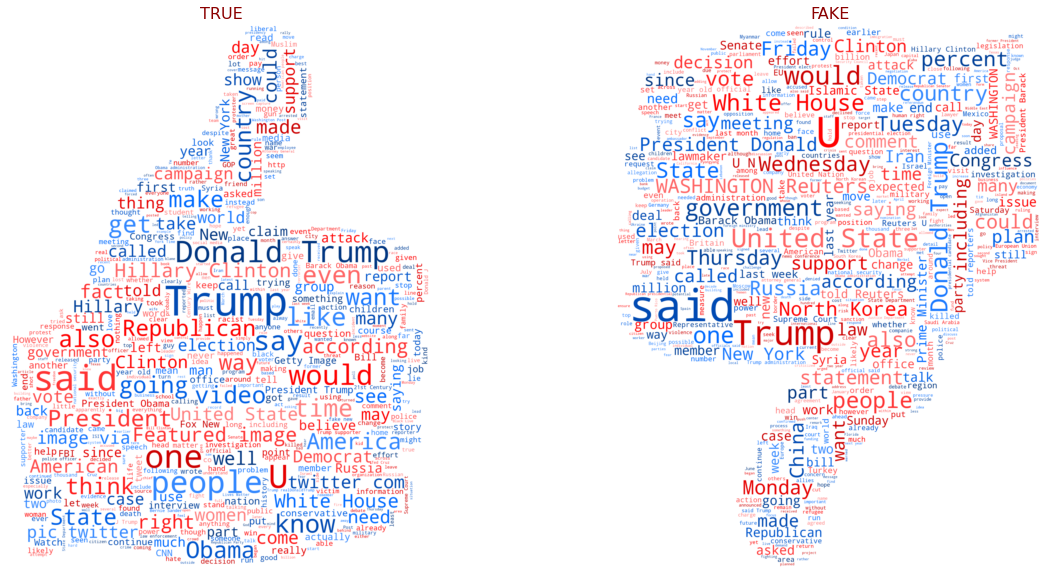

In [83]:
tuples_pos = Coef_reg_model_positive.set_index('words').T.to_dict('index')
tuples_neg = Coef_reg_model_negative.set_index('words').T.to_dict('index')

wordcloud_positive = WordCloud(max_words=500, mask=mask_pos,
        background_color="white").generate_from_frequencies(dict(tuples_pos['freq']))
wordcloud_negative = WordCloud(max_words=500, mask=mask_neg,
        background_color="white").generate_from_frequencies(dict(tuples_neg['freq']))

graficos_manos(fake = wordcloud_fake,true = wordcloud_true)

## Modelo de Reg. Logistica Truncando palabras

In [86]:
# Respondo la pregunta de la celda de abajo: No, debería ser siempre Train para entrenar los datos
# Además al usar test se reduce el número de componentes.
# Ya mostramos este gráfico, por qué acá está de nuevo?

In [25]:
# Esta bien que sea tfidf test????

test_svd = TruncatedSVD(n_components = X_test.shape[1] - 1);
test_svd.fit(X_test)
tsvd_var_ratios = test_svd.explained_variance_ratio_
desired_threshold_90 = 0.90
desired_threshold_50 = 0.50
desired_threshold_10 = 0.10
n_components_90 = select_n_components(tsvd_var_ratios, desired_threshold_90)
n_components_50 = select_n_components(tsvd_var_ratios, desired_threshold_50)
n_components_10 = select_n_components(tsvd_var_ratios, desired_threshold_10)


IndexError: tuple index out of range

In [161]:
svd_90 = TruncatedSVD(n_components = n_components_90)
svd_50 = TruncatedSVD(n_components = n_components_50)
svd_10 = TruncatedSVD(n_components = n_components_10)

X_train_svd_90 = svd_90.fit_transform(X_train)
X_test_svd_90 = svd_90.transform(X_test)
X_train_svd_50 = svd_50.fit_transform(X_train)
X_test_svd_50 = svd_50.transform(X_test)
X_train_svd_10 = svd_10.fit_transform(X_train)
X_test_svd_10 = svd_10.transform(X_test)

In [162]:
X_svd = [[X_train_svd_90,X_test_svd_90],[X_train_svd_50,X_test_svd_50],[X_train_svd_10,X_test_svd_10]]
scores = []
models = []
for svd in X_svd:

    reg_model_svd = LogisticRegression(C = 8, solver="newton-cg", penalty="l2")
    models.append(reg_model_svd.fit(svd[0], y_train))
    scores.append(reg_model_svd.score(svd[1], y_test))

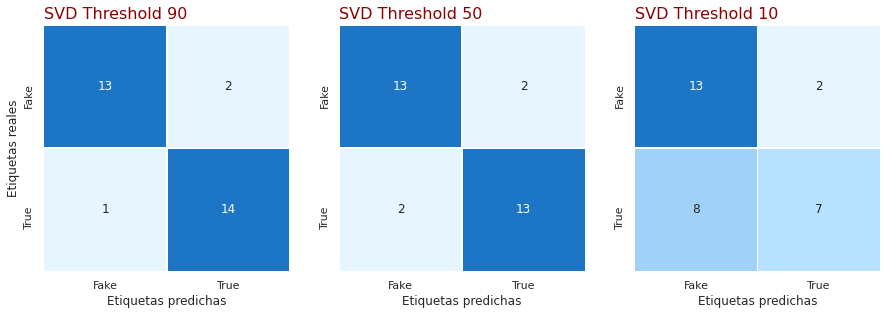

In [163]:
figs, axs = plt.subplots(1,3, figsize= (15,5))
title = [90,50,10]
for i in range(3):
    
    cm_rlog_svd = confusion_matrix(y_test, models[i].predict(X_svd[i][1]))
    sns.heatmap(cm_rlog_svd,xticklabels=axis_labels, yticklabels=axis_labels,
                cbar=False, annot=True, cmap=cmap, fmt='d', ax = axs[i],
                linecolor = "w" , linewidths = .5,square=True)
    axs[i].set_title(label = f'SVD Threshold {title[i]}' , 
    loc ='left', fontdict = font )
    axs[0].set_ylabel('Etiquetas reales')
    axs[i].set_xlabel('Etiquetas predichas')

## Decision Tree Classifier

In [164]:
my_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
my_tree.fit(X_train, y_train)
my_tree.score(X_test, y_test)

0.5666666666666667

Text(0.5, 12.5, 'Etiquetas predichas')

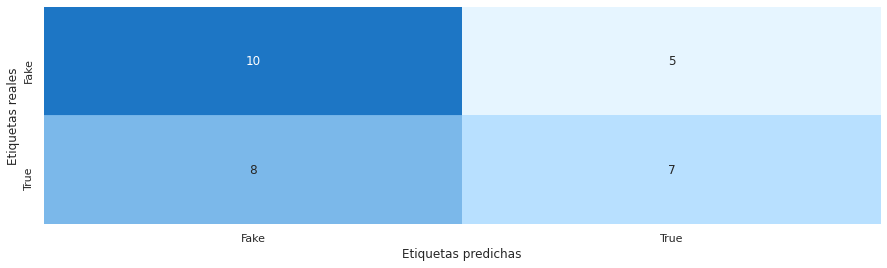

In [165]:
cm_tree = confusion_matrix(y_test, my_tree.predict(X_test))
sns.heatmap(cm_tree, xticklabels=axis_labels, yticklabels=axis_labels,
            cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')

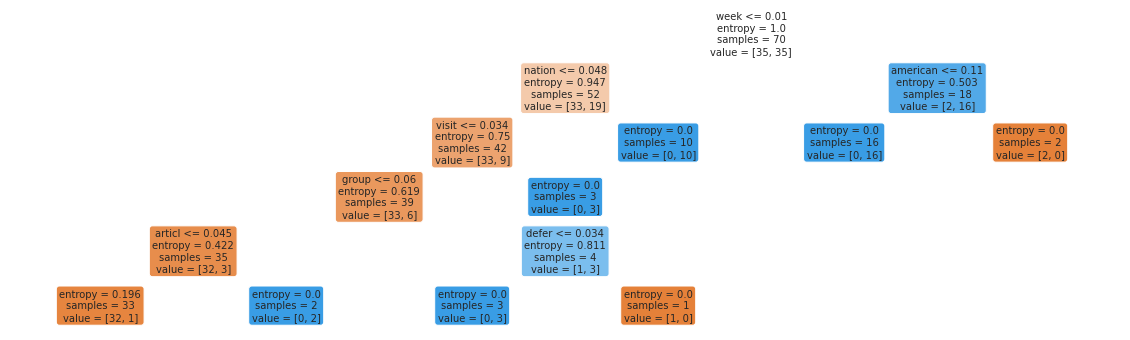

In [166]:
plt.figure(figsize=(20,6))
tree.plot_tree(my_tree,feature_names = customized_vectorizer.get_feature_names(),
                filled=True,rounded=True, fontsize = 10)
plt.show()

## Boosting de Modelos

In [167]:
base_classifier = ExtraTreesClassifier(n_estimators=100, 
                                      criterion='gini', 
                                      max_depth = 4, 
                                      bootstrap=True, 
                                      n_jobs = -1, 
                                      random_state = 127,
                                      max_samples= 0.3)

boost_tree = AdaBoostClassifier(base_estimator = base_classifier, 
                            n_estimators = 200,
                            learning_rate = 0.8,                                       
                            random_state = 127)

boost_tree.fit(X_train, y_train) 
boost_tree.score(X_test, y_test)

0.9333333333333333

Text(0.5, 12.5, 'Etiquetas predichas')

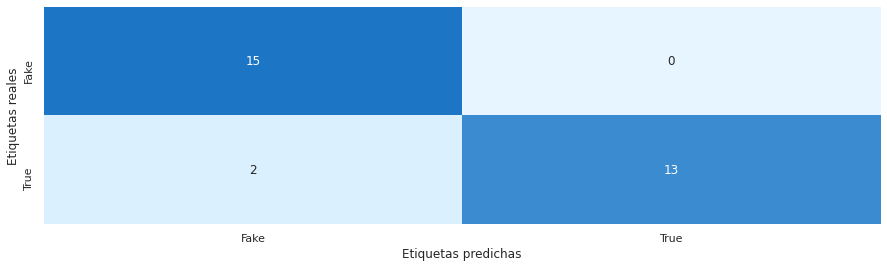

In [168]:
cm_boost_tree = confusion_matrix(y_test, boost_tree.predict(X_test))
sns.heatmap(cm_boost_tree, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')

## Evaluación de los modelos - ROC CURVE  

In [ ]:
"""# Calculo de probabilidad de los distintos modelos
y_pred_boost = boost_tree.predict_proba(X_test)
y_pred_my_tree = my_tree.predict_proba(X_test)
y_pred_reg_model = reg_model.predict_proba(X_test)
y_pred_NB = NB_model.predict_proba(X_test)

models = models.append(boost_tree,)"""



In [ ]:
"""def ROC_curve(modelos, X_test , y_test):
    "Calcula las probabilidades y grafica la ROC Curve de los modelos
    en lista 'Modelos'. "
    for model in modelos:
        y_pred_proba = model.predict_proba(X_test)
        fpr_log, tpr_log, thr_log = roc_curve(y_test, y_pred_proba[:,1])
        df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))
        plt.plot(df['fpr'],df['tpr'], label='Modelo')
    
    plt.axis([0, 1.01, 0, 1.01]); plt.legend()
    plt.xlabel('1 - Specificty'); plt.ylabel('TPR / Sensitivity'); plt.title('ROC Curve')
    plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
    plt.show()

ROC_curve(modelos = models, X_test = X_test , y_test = y_test)"""

In [ ]:
# ESTO LO AGREGAMOS?

In [ ]:
"""X_train_dense = pd.DataFrame(X_train.todense(), columns=count_vectorizer.get_feature_names_out())
X_train_explainer = np.array(X_train_dense)
explainer = LimeTabularExplainer(X_train_explainer, 
                                 mode = "classification",
                                 training_labels = y_train,
                                 feature_names = count_vectorizer.get_feature_names_out(),
                                 discretize_continuous=False)"""

In [ ]:
"""data_row = np.array(X_test[0].todense())[0]

explanation = explainer.explain_instance(data_row, reg_model.predict_proba, num_features=10)
explanation.as_pyplot_figure()"""

In [177]:
# Podríamos agregar alguna conclusión de los modelos que fuimos probando, podemos agregar un gráfico
# comparando los accuracy

## Pipeline

In [95]:
# Estamos repitiendo de nuevo el sampleo de los datos

In [20]:
testing_sample_size = 100 # Algunas operaciones se demoran mucho tiempo, tamaño pequeño es para agilizarlas

data_sample = data.sample(testing_sample_size)
X = data_sample['text']
y = data_sample['real']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


In [21]:
pasos = [('vectorizador', CountVectorizer()),
         ('tfidf', TfidfTransformer()), 
         ('cambio_base', TruncatedSVD()),
         ('modelo', LogisticRegression())]
pipeline = Pipeline(pasos)

In [31]:
# clase para generar cambios de base con diferente número de componentes
class SVD_n_components(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit(self, X, y):
        return self
    
    def transform(self, X, y):
        svd = TruncatedSVD(n_components = self.n_components);
        return svd.fit_transform(X, y)
    
n_components_90 = 10
n_components_50 = 11
n_components_10 = 12


In [28]:
n_components_90

10

In [ ]:
# No le veo sentido a poner min_df y max_df al mismo tiempo, están indicando lo mismo
# Quizás haría un range de números enteros del 1 al 10 más que por proporción en float
# Le puse un lancaster_tokenizer, ojo que en un comentario habíamos dicho que lancaster no servía

In [34]:
param_grid = [{ 'vectorizador__lowercase': [True],
                'vectorizador__strip_accents': ['unicode'],   
                'vectorizador__ngram_range': [(1, 4), (2, 4), (3, 4), (4, 4)],
                'vectorizador__max_df': np.arange(0.95, 1, 0.01) ,
                'vectorizador__tokenizer': [porter_tokenizer, lancaster_tokenizer],
                'tfidf__norm': ['l1', 'l2'],
                'cambio_base': [SVD_n_components(n_components_10),
                                SVD_n_components(n_components_50),
                                SVD_n_components(n_components_90),
                                None],
               'modelo': [AdaBoostClassifier(), LogisticRegression()],
                #ExtraTreesClassifier() , ()]
               }]

In [ ]:
# Apróximadamente toma 10 min la ejecución con un sample de 1000 records y param_grid2
folds=StratifiedKFold(n_splits=5,shuffle=True)
grid = GridSearchCV(estimator = pipeline,param_grid = param_grid, cv = folds)
grid.fit(X_train, y_train)

In [ ]:
grid.best_score_

In [ ]:
grid.best_estimator_

In [ ]:
grid.best_params_

##### Grid Search Testing

In [ ]:
y_pred_grid = grid.predict(X_test)
"""confusion = confusion_matrix(y_test, y_pred_grid)
print(confusion)"""
confusion_grid = confusion_matrix(y_test, y_pred_grid)
sns.heatmap(confusion_grid, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')
print (classification_report(y_test, y_pred_grid))

## Exportación de mejor modelo entrenado
Se realiza con pickle

In [174]:
# Podríamos poner el modelo de picles en otro directorio para que no se mezcle

In [119]:
# Escritura del modelo
with open('fakenews_model.pkl', 'wb') as f_model:
    pickle.dump(grid.best_estimator_, f_model)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [169]:
# Si se quiere probar pickles sin el modelo de grid descomentar esta celda
# Escritura del modelo
# with open('fakenews_model.pkl', 'wb') as f_model:
#     pickle.dump(boost_tree, f_model)

In [170]:
# Lectura del modelo
with open('fakenews_model.pkl', 'rb') as f_model:
        fakenews_model = pickle.load(f_model)

              precision    recall  f1-score   support

        Fake       0.88      1.00      0.94        15
        True       1.00      0.87      0.93        15

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



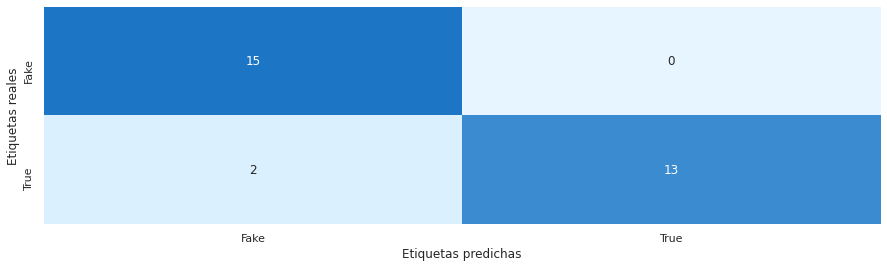

In [171]:
y_pred_grid = fakenews_model.predict(X_test)
"""confusion = confusion_matrix(y_test, y_pred_grid)
print(confusion)"""
confusion_grid = confusion_matrix(y_test, y_pred_grid)
sns.heatmap(confusion_grid, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')
print (classification_report(y_test, y_pred_grid))

## WEB APP

In [178]:
# No sé si es necesario poner 2 guiones bajos en el nombre de la app, se usan los 2 cuando se pone __name__
# Quedó dando vueltas la función fn_select_proba que no se está usando
# Por qué quedó reg_model como ubicación del modelo, ya se sabe que es de reg logística?
# Creo que quedó un test2 dando vueltas que habría que sacar
# No me deja correr el modelo, probé desde el html renderizado y desde una url que construí en el browser,
# las dos formas me tira un Internal Server Error
# Está chequeado que los 2 últimos argumentos en el return de mi_modelo se pueden usar en el script del html?
# No estamos haciendo el pre procesamiento del texto, habría que meterlas en un CountVectorizer, podemos
# armar un pipeline de pre procesamiento
# No entendí el regex que se está metiendo en el script de .replace(/\//g, " ")

In [ ]:
# Importar
from flask import Flask
from flask import render_template
from utils import *

app = Flask('my__webapp')

def fn_select_proba(value="True"):
    if value == "Fake":
        return 0
    else:
        return 1

@app.route('/reg_model/<text>', methods=['GET'])
def mi_modelo(text):
    # Lectura del modelo
    with open('fakenews_model.pkl', 'rb') as f_model:
        fakenews_model = pickle.load(f_model)


    text_df = pd.Series(data = text)

    result = {"predict": fakenews_model.predict(text_df)[0]}
    result_proba = {"predict": np.round(fakenews_model.predict_proba(text_df),2)}
    
    return render_template('predict_page.html', predict=result["predict"] ,
     predict_proba=result_proba["predict"][0])  

@app.route('/reg_model/', methods=['GET'])
def home():
    return render_template('home.html')      

@app.route("/test", methods=['GET'])
def hello():
    alive = "La app está viva"
    return alive


app.run(host='0.0.0.0', port = 5017)

Abrimos en un browser esta url (GET)

[Test WEB APP](http://localhost:5017/test)


[FAKE NEWS PREDICTION](http://localhost:5017/reg_model/)

http://localhost:5017/test2

## Pipeline con título de las noticias (SIN contenido del texto)

In [ ]:
# Hacer el pipeline sólamente con los títulos de las noticias para ver qué pasa

## A traves de webscraping se buscan noticias para obtener más datos de testing

In [ ]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome(service=Service(ChromeDriverManager().install()),options=chrome_options)

def get_text_from_url_bbc(url):
    wd.get(url)

    time.sleep(1)

    soup = BeautifulSoup(wd.page_source)
    text = soup.find_all('div', {'data-component': 'text-block'}) #(?P<text>\>(.*?)\<)
    text = reversed(text) 
    text2 = ""
    for i in text:
        try:
            text2 = i.text+text2
        except:
            text2 = ""+text2
    return text2    

In [ ]:
warnings.filterwarnings("ignore")
#https://newsapi.org/docs
response = requests.get("https://newsapi.org/v2/top-headlines?sources=bbc-news&apiKey=1f83e742c8804de0a5d427510829f79b")

list_urls = []
for i in range(0,len(response.json()['articles'])):
    list_urls.append(response.json()['articles'][i]['url'])  
    
list_texts = []
for i in range(0,len(list_urls)):
    list_texts.append(get_text_from_url_bbc(list_urls[i]))

In [ ]:
def clean_review(review_text, tokenizer, stemmer, stopwords):    
    
    #tokens (eliminamos todos los signos de puntuación)
    words = tokenizer.tokenize(review_text)
    
    # stemming: raiz y minúsculas:
    stem_words = [stemmer.stem(x) for x in words]
    
    # eliminamos stopwords (ya pasaron por stem)
    clean_words = [x for x in stem_words if x not in stopwords]
    
    result = " ".join(clean_words)
    
    return(result)

In [ ]:
data_texts_text = pd.DataFrame(list_texts, columns=['text'])
data_texts_text['len'] = data_texts_text.text.apply(lambda x: len(x))
data_texts_text['real'] = 'True'
data_texts_text = data_texts_text[data_texts_text.len>0]

clean_texts_test = data_texts_text.text.apply(lambda x: porter_tokenizer(x))

X_test_sparse_texts = customized_vectorizer.transform(clean_texts_test)
X_test_texts = pd.DataFrame(X_test_sparse_texts.todense(), 
             columns = customized_vectorizer.get_feature_names()) 
X_test_svd_texts = svd.transform(X_test_texts)
"""X_test_bigram_sparse_texts = count_vectorizer_bigram.transform(clean_texts_test)"""

In [ ]:
data_texts_text['predict_reg_base'] = reg_model.predict(X_test_texts)
data_texts_text['predict_prob_reg_base'] = reg_model.predict_proba(X_test_texts).T[0]

data_texts_text['predict_svd'] = reg_model_svd.predict(X_test_svd_texts)
data_texts_text['predict_prob_svd'] = reg_model_svd.predict_proba(X_test_svd_texts).T[0]

"""data_texts_text['predict_bigram'] = reg_model_bigram.predict(X_test_bigram_sparse_texts)
data_texts_text['predict_prob_bigram'] = reg_model_bigram.predict_proba(X_test_bigram_sparse_texts).T[0]
"""
data_texts_text['predict_my_tree'] = my_tree.predict(X_test_texts)
data_texts_text['predict_prob_my_tree'] = my_tree.predict_proba(X_test_texts).T[0]

data_texts_text

In [ ]:
X_train_explainer = np.array(X_train)
explainer = LimeTabularExplainer(X_train_explainer, 
                                 mode = "classification",
                                 training_labels = y_train,
                                 feature_names = X_train.columns,
                                 discretize_continuous=False)

#i = 13
#data_row = np.array(X_test.iloc[i])
data_row = np.array(X_test_texts.iloc[4])
explanation = explainer.explain_instance(data_row, reg_model.predict_proba, num_features=10)
explanation.as_pyplot_figure();

In [ ]:
data_texts_text.text.iloc[4]